In [136]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import yfinance as yf

## Data Entry
### (To-Do: Create CLI after code backtested and finalized)

In [137]:
# Import user inputs
%store -r ticker
%store -r start_date
%store -r end_date
%store -r short_window
%store -r long_window

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Step 1: Define the strategy

In [138]:
# Define SMA

def SMA(data, window):
    return data.rolling(window=window).mean()

def SMA_crossover_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['short_SMA'] = SMA(data['Close'], short_window)
    signals['long_SMA'] = SMA(data['Close'], long_window)
    signals['signal'] = 0.0

    signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)

    signals['positions'] = signals['signal'].diff()

    return signals

# Step 2: Create Strategy Dataframe

In [139]:
# Create dataframe of strategy
signals = SMA_crossover_strategy(data, short_window, long_window)
display(signals.head(150))

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2020-10-20,160.850494,NaN,NaN,0.0,NaN
2020-10-21,159.246994,NaN,NaN,0.0,0.0
2020-10-22,158.820007,NaN,NaN,0.0,0.0
2020-10-23,160.220001,NaN,NaN,0.0,0.0
2020-10-26,160.352005,NaN,NaN,0.0,0.0
...,...,...,...,...,...
2021-05-19,161.589996,161.415800,166.261300,0.0,0.0
2021-05-20,162.384003,161.122351,166.175267,0.0,0.0
2021-05-21,160.154007,160.679701,165.893400,0.0,0.0


In [140]:
# Filter the DataFrame to show only the rows with buy or sell signals
signal_data = signals.loc[signals['positions'].abs() == 1]

# Display the resulting DataFrame
display(signal_data)

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2020-12-03,159.336502,157.958298,157.884351,1.0,1.0
2020-12-16,162.048004,157.848799,157.961066,0.0,-1.0
2020-12-17,161.804001,158.095549,157.952600,1.0,1.0
2021-01-13,158.294495,159.160449,159.399684,0.0,-1.0
2021-01-26,166.306503,160.609650,160.268534,1.0,1.0
2021-02-24,157.976501,162.584550,162.769566,0.0,-1.0
2021-04-01,158.050003,154.473950,154.443384,1.0,1.0
2021-05-12,157.597000,165.359750,166.038266,0.0,-1.0
2021-06-14,169.193497,163.347449,162.657816,1.0,1.0


# Step 3: Plot SMA Crossover for Selected Ticker

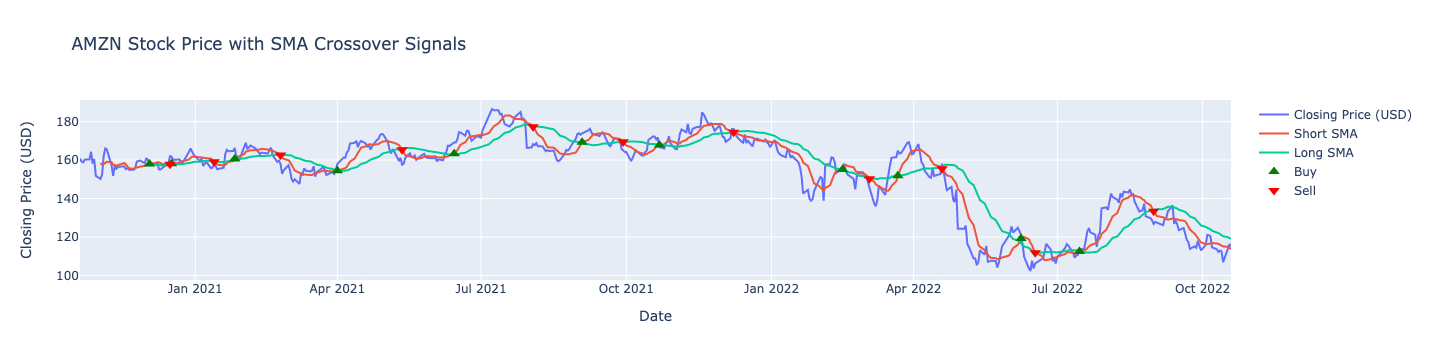

In [141]:
# Define the stock price trace
price = go.Scatter(
    x=data.index,
    y=data['Close'],
    name='Closing Price (USD)',
)

# Define the short SMA trace
short_sma = go.Scatter(
    x=signals.index,
    y=signals['short_SMA'],
    name='Short SMA',
)

# Define the long SMA trace
long_sma = go.Scatter(
    x=signals.index,
    y=signals['long_SMA'],
    name='Long SMA',
)

# Define the buy signals trace
buy_signals = go.Scatter(
    x=signals.loc[signals.positions == 1.0].index,
    y=signals.short_SMA[signals.positions == 1.0],
    name='Buy',
    mode='markers',
    marker=dict(size=10, symbol='triangle-up', color='green'),
)

# Define the sell signals trace
sell_signals = go.Scatter(
    x=signals.loc[signals.positions == -1.0].index,
    y=signals.short_SMA[signals.positions == -1.0],
    name='Sell',
    mode='markers',
    marker=dict(size=10, symbol='triangle-down', color='red'),
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'{ticker} Stock Price with SMA Crossover Signals'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price (USD)'),
)

# Create the figure
fig = go.Figure(data=[price, short_sma, long_sma, buy_signals, sell_signals], layout=layout)

# Display the figure
fig.show()

# Step 4: Measure Cumulative Returns

In [142]:
# Calculate daily returns
signals['daily_returns'] = signals['price'].pct_change()

# Calculate daily returns when following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Filter out the periods when not holding the stock (strategy_returns == 0)
holding_returns = signals[signals['strategy_returns'] != 0]['strategy_returns']
cumulative_strategy_returns = (1 + holding_returns).cumprod()

display(cumulative_strategy_returns)

Date
2020-10-20         NaN
2020-12-04    0.992422
2020-12-07    0.990984
2020-12-08    0.997038
2020-12-09    0.974102
                ...   
2022-08-25    0.888755
2022-08-26    0.846479
2022-08-29    0.840264
2022-08-30    0.833402
2022-08-31    0.820713
Name: strategy_returns, Length: 230, dtype: float64

In [143]:
# Calculate cumulative returns for buy-and-hold strategy
buy_and_hold_cumulative_returns = (1 + signals['daily_returns']).cumprod()

display(buy_and_hold_cumulative_returns)

Date
2020-10-20         NaN
2020-10-21    0.990031
2020-10-22    0.987377
2020-10-23    0.996080
2020-10-26    0.996901
                ...   
2022-10-13    0.699594
2022-10-14    0.664592
2022-10-17    0.707427
2022-10-18    0.723405
2022-10-19    0.715385
Name: daily_returns, Length: 504, dtype: float64

# Step 5: Plot Cumulative Returns

### SMA Crossover

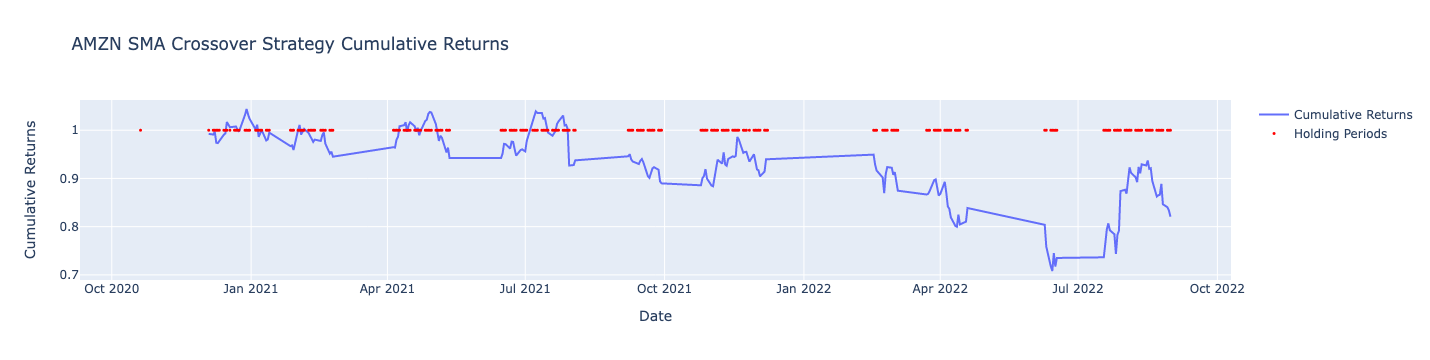

In [144]:
# Create a trace for the cumulative returns
cumulative_returns_trace = go.Scatter(
    x=cumulative_strategy_returns.index,
    y=cumulative_strategy_returns.values,
    mode='lines',
    name='Cumulative Returns'
)

# Create a trace for the holding periods
holding_periods_trace = go.Scatter(
    x=holding_returns.index,
    y=[1] * len(holding_returns),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Holding Periods'
)

# Create a layout for the chart
layout = go.Layout(
    title=dict(text=f'{ticker} SMA Crossover Strategy Cumulative Returns'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
)

# Create the figure
fig = go.Figure(data=[cumulative_returns_trace, holding_periods_trace], layout=layout)

# Display the figure
fig.show()

### Buy and Hold

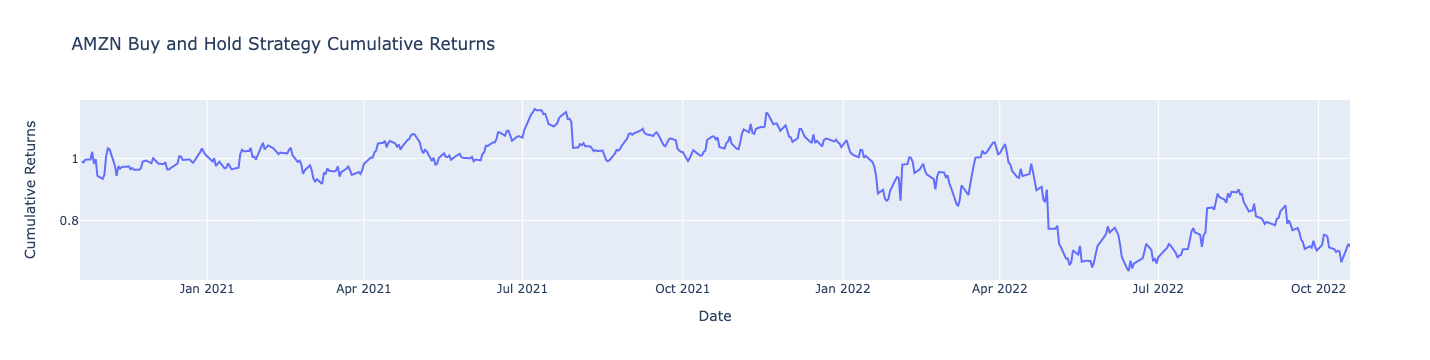

In [145]:
# Define the buy-and-hold strategy trace
buy_and_hold_cumulative_returns_trace = go.Scatter(
    x=buy_and_hold_cumulative_returns.index,
    y=buy_and_hold_cumulative_returns,
    mode='lines',
    name='Buy and Hold Strategy'
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'{ticker} Buy and Hold Strategy Cumulative Returns'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
)

# Create the figure
fig = go.Figure(data=[buy_and_hold_cumulative_returns_trace], layout=layout)

# Display the figure
fig.show()

# Step 6: Compare Returns

### Plot Comparison

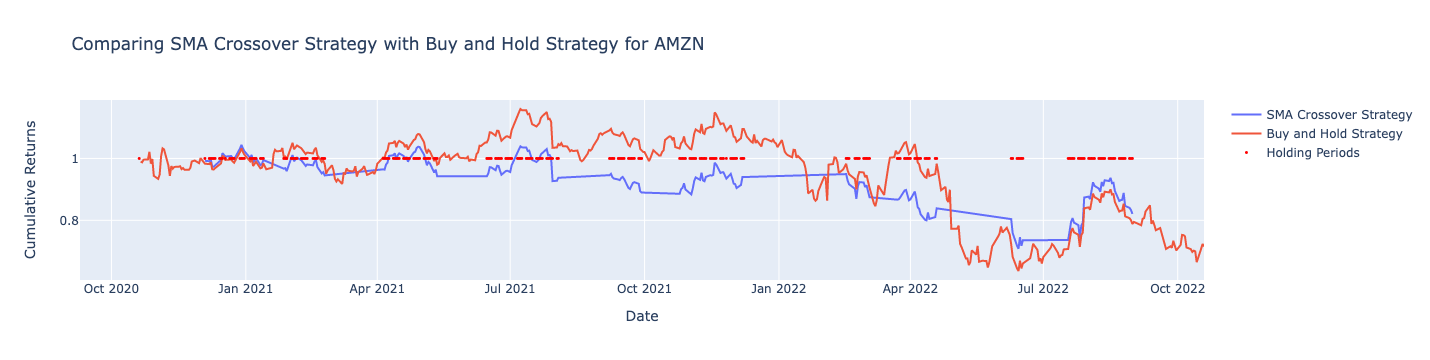

In [146]:

# Define the SMA Crossover strategy trace
sma_crossover_strategy = go.Scatter(
    x=holding_returns.index,
    y=cumulative_strategy_returns,
    mode='lines',
    name='SMA Crossover Strategy'
)

# Define the buy-and-hold strategy trace
buy_and_hold_strategy = go.Scatter(
    x=buy_and_hold_cumulative_returns.index,
    y=buy_and_hold_cumulative_returns,
    mode='lines',
    name='Buy and Hold Strategy'
)

# Define holding periods trace
holding_periods_trace = go.Scatter(
    x=holding_returns.index,
    y=[1] * len(holding_returns),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Holding Periods'
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'Comparing SMA Crossover Strategy with Buy and Hold Strategy for {ticker}'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
)

# Create the figure
fig = go.Figure(data=[sma_crossover_strategy, buy_and_hold_strategy, holding_periods_trace], layout=layout)

# Display the figure
fig.show()

# Step 7: Compare Risk

###  Crossover Strategy Volatility

In [147]:
# Calculate the annualized volatility
annualized_volatility_SMA = holding_returns.std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", holding_returns.std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility_SMA)

Standard Deviation: 0.020523200000784007
Annualized Volatility: 0.3257956998558906


### Buy and Hold Strategy Volatility

In [148]:
# Calculate the annualized volatility
annualized_volatility = signals['daily_returns'].std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", signals['daily_returns'].std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility)

Standard Deviation: 0.023563636317420637
Annualized Volatility: 0.37406113008158914


### Sharpe Ratio

In [151]:
# Calculate the Sharpe Ratio

# Calculate daily returns when holding the stock following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Calculate the average daily returns
average_daily_returns = signals['daily_returns'].mean()
average_strategy_returns = signals['strategy_returns'].mean()

# Calculate the standard deviation of daily returns (volatility)
volatility_daily_returns = signals['daily_returns'].std()
volatility_strategy_returns = signals['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sharpe ratios
sharpe_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / volatility_daily_returns
sharpe_ratio_strategy = (average_strategy_returns - risk_free_rate) / volatility_strategy_returns

# Print the Sharpe ratios
print("Sharpe Ratio (Buy and Hold Strategy):", sharpe_ratio_buy_and_hold)
print("Sharpe Ratio (SMA Crossover Strategy):", sharpe_ratio_strategy)


Sharpe Ratio (Buy and Hold Strategy): -0.019808722085896856
Sharpe Ratio (SMA Crossover Strategy): -0.027243045804744424


### Sortino Ratio

In [152]:
# Calculate the Sortino Ratio

# Calculate the downside deviations (considering only negative returns)
downside_deviation_daily_returns = signals[signals['daily_returns'] < 0]['daily_returns'].std()
downside_deviation_strategy_returns = signals[signals['strategy_returns'] < 0]['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sortino ratios
sortino_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / downside_deviation_daily_returns
sortino_ratio_strategy = (average_strategy_returns - risk_free_rate) / downside_deviation_strategy_returns

# Print the Sortino ratios
print("Sortino Ratio (Buy and Hold Strategy):", sortino_ratio_buy_and_hold)
print("Sortino Ratio (SMA Crossover Strategy):", sortino_ratio_strategy)


Sortino Ratio (Buy and Hold Strategy): -0.027044404065460163
Sortino Ratio (SMA Crossover Strategy): -0.0284949439842295


# Step 8: Create Plot for Comparison of Volatilities/Ratios

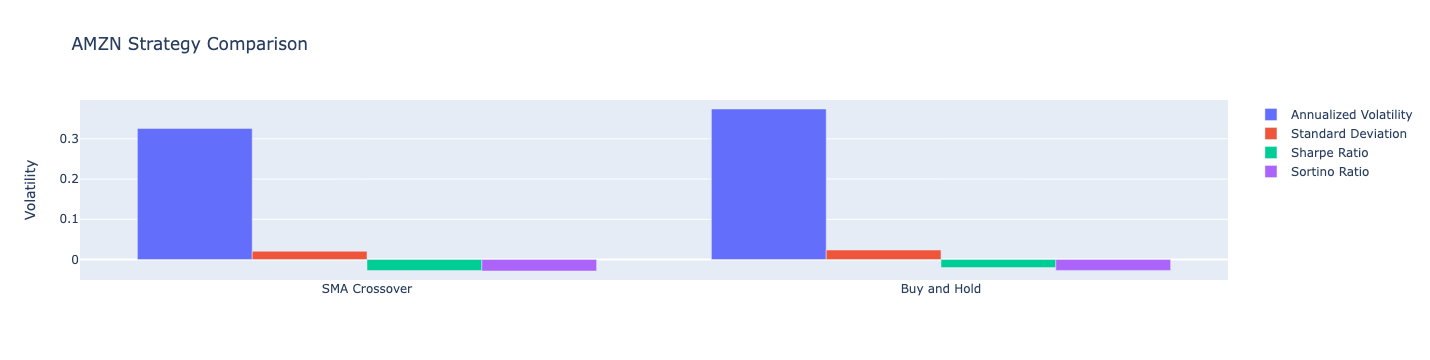

In [153]:
# Create a bar chart of annualized volatility, standard deviation, Sharpe ratio, and Sortino ratio
fig = go.Figure()
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[annualized_volatility_SMA, annualized_volatility],
                     name='Annualized Volatility'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[holding_returns.std(), signals['daily_returns'].std()],
                     name='Standard Deviation'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[sharpe_ratio_strategy, sharpe_ratio_buy_and_hold],
                     name='Sharpe Ratio'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[sortino_ratio_strategy, sortino_ratio_buy_and_hold],
                     name='Sortino Ratio'))

fig.update_layout(title=f'{ticker} Strategy Comparison', barmode='group',
                  yaxis=dict(title='Volatility'))

fig.show()

### Maximum Drawdown

In [74]:
# Drop rows with missing or invalid values
signals.dropna(inplace=True)

# Calculate the running maximum cumulative returns
signals['running_max_bh'] = signals['buy_and_hold_cumulative_returns'].cummax()
signals['running_max_strategy'] = signals['strategy_cumulative_returns'].cummax()

# Check for any negative or zero values in the running maximum cumulative returns
print("Negative or zero values in 'running_max_bh':\n", signals[signals['running_max_bh'] <= 0])
print("Negative or zero values in 'running_max_strategy':\n", signals[signals['running_max_strategy'] <= 0])

# Calculate the drawdown for each time step
signals['drawdown_bh'] = signals['buy_and_hold_cumulative_returns'] / signals['running_max_bh'] - 1
signals['drawdown_strategy'] = signals['strategy_cumulative_returns'] / signals['running_max_strategy'] - 1

# Find the maximum drawdown for each strategy
max_drawdown_buy_and_hold = signals['drawdown_bh'].min()
max_drawdown_strategy = signals['drawdown_strategy'].min()

# Print the maximum drawdowns
print("Maximum Drawdown (Buy and Hold):", max_drawdown_buy_and_hold)
print("Maximum Drawdown (SMA Crossover Strategy):", max_drawdown_strategy)


KeyError: 'buy_and_hold_cumulative_returns'